# 🎓 **Taller 4.2: Taller de Métodos de clustering basados en particiones**


## OBJETIVOS DEL TALLER:
En esta práctica estudiaremos el funcionamiento y la utilización métodos de clustering basados en particiones, como el K-means y el K-medoids.

# 🔧 **CONFIGURACIÓN INICIAL**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it

from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

plt.rcParams['figure.figsize'] = [8, 8]

# 📁 **CARGAR LOS DATASETS Y GRAFICAR SUS DISTRIBUCIONES**

In [ ]:
# Cargar dataset artificial
def cargar_dataset(nombre_dataset):
    try:
        # Intentar cargar desde URL alternativa
        data_file_url = "https://raw.githubusercontent.com/SandraNavarrete-docente/aprendizaje-automatico-252601/main/04-MODELOS-NO-SUPERVISADOS/data/"+nombre_dataset
        D = np.array(pd.read_excel(data_file_url,header=0))
        print("✅ Dataset cargado desde URL GitHub")
        return D
    except:
        print("❌ No se pudo cargar el dataset")
        return None

✅ Dataset cargado desde URL GitHub


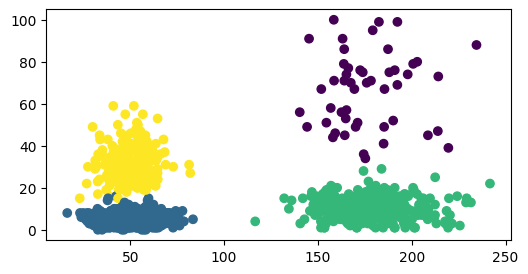

In [ ]:
# Cargar dataset
D =cargar_dataset("dataset_cuatro_diferente_densidad.xlsx")
Dx = D[:,0:2]
Dy = D[:,2]
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dy)

# 🎯 **EJ 1:Cree el algoritmo K-means que tiene un único parámetro: el número de clústeres (K).**

In [17]:
# PASO 1 elejir los centros iniciales de forma randomica
def random_sample_float(n, mi, ma):
    return (ma - mi) * np.random.random_sample(n) + mi

def paso1_elije_centros(K, Dx):
  cDx = np.zeros(K*Dx.shape[1])
  cDx.shape = (K,Dx.shape[1])
  # 1.1 Completa el codigo aqui
  x1= random_sample_float(K, np.min(Dx[:,0]), np.max(Dx[:,0]))
  x2= random_sample_float(K, np.min(Dx[:,1]), np.max(Dx[:,1]))
  cDx[:,0] = x1
  cDx[:,1] = x2
  return cDx


Los centros iniciales elegidos aleatoriamente son:
[[ 84.60971135  45.24975263]
 [192.08302882  62.89358198]
 [103.38793243  56.97680369]
 [200.39243669  84.87178661]]


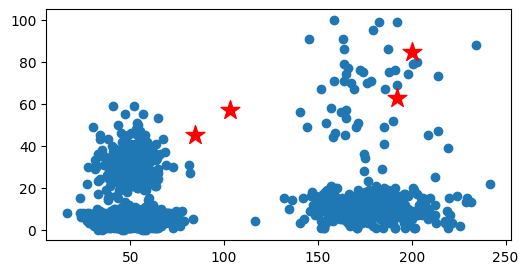

In [18]:
print('Los centros iniciales elegidos aleatoriamente son:')
K=4
cDx = paso1_elije_centros(K, Dx)
print(cDx)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1])
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

2.   Paso de asignación de datos
En este paso, cada elemento de nuestro dataset se asigna al centroide más cercano basado en la distancia escogida: en nuestro caso, la Euclidiana. Por tanto, tendremos que implementar la siguiente operación:

$$
\DeclareMathOperator*{\argminA}{arg\,min}
\argminA_{c_i \in C} dist\left ( c_i, x \right )^2
$$

In [19]:
# Definimos la distancia euclidiana de una instancia x con respecto a un grupo de instancias C
def distancia_euclidiana_grupo(x, C):
  return np.linalg.norm(C - x, axis=1);

def paso2_asigna_puntos(Dx, cDx):
  Dyp = np.zeros(Dx.shape[0])
  # Buscamos el centro más cercano a cada instancia y la asignamos a ese clúster
  for i in np.arange(Dx.shape[0]):
      # Tenemos que calcular la distancia de cada muestra del dataset Dx[i]
      # a cada centro existente en cDx. Podemos utilizar para ello la función
      # distancia_euclidiana_grupo.

      distancia_punto_a_centros =  distancia_euclidiana_grupo(Dx[i], cDx)

      # Una vez calculada la distancia, necesitamos averiguar el índice de
      # la distancia mínima. Para ello, podemos usar la función argmin de numpy.
      pred_y = np.argmin(distancia_punto_a_centros)
      Dyp[i] = pred_y
  return Dyp

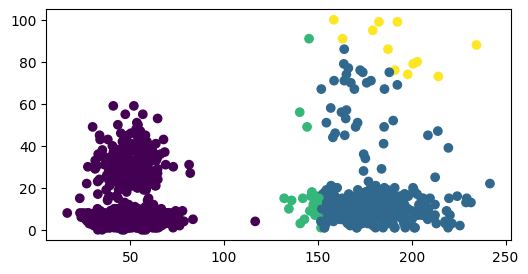

In [20]:
Dyp = paso2_asigna_puntos(Dx, cDx)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)

2.   Paso de actualización del centroide
En este paso se recalcula el centroide de cada cluster, teniendo en cuenta la nueva asignación calculada en el paso 1. Para ello, se calcula la media de todos los puntos asignados en el paso anterior.

$$
c_i = \frac{1}{\left | S_i \right |} \sum_{x_i \in S_i} x_i
$$


In [22]:
def paso3_actualiza_centros(Dx, cDx, Dyp, K):
  cDx_ant = cDx.copy()
  for k in range(K):
      # Seleccionamos los puntos asignados al cluster k
      puntos_cluster_k = Dx[Dyp == k]
      # Calculamos la media de las coordenadas x e y
      if len(puntos_cluster_k) > 0:  # Evitar división por cero si el cluster está vacío
          cDx[k,:] =  np.mean(puntos_cluster_k,axis=0)
      else:
          # Si el cluster está vacío, mantenemos el centroide anterior
          cDx[k,:] = cDx_ant[k,:]
  return cDx

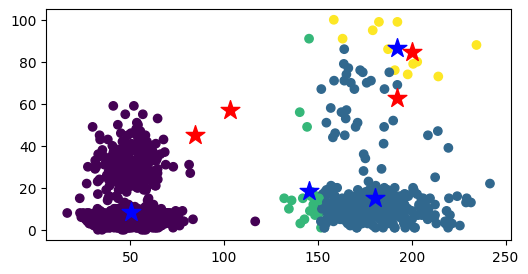

In [23]:
cDx_ant = cDx.copy()
cDx =paso3_actualiza_centros(Dx, cDx, Dyp, K)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='b')
ax.scatter(cDx_ant[:,0],cDx_ant[:,1], marker='*', s=200, c='r')

Y esto es todo. Este proceso se repite hasta cumplir un criterio de detención:

*   No hay cambios en los puntos asignados a cada cluster
*   La suma de las distancias alcanza un valor mínimo establecido
*   Se alcanza un número máximo de iteraciones

In [27]:
def MyKMeans(Dx, K):
  cDx = paso1_elije_centros(K, Dx)
  cDxIni = cDx.copy()
  # Flag de convergencia
  iterando = True
  while iterando:
    # Vector auxiliar para guardar los centros de la iteración pasada
    # necesarios para identificar la convergencia
    cDx_ant = cDx.copy()
    Dyp = paso2_asigna_puntos(Dx, cDx)# 1.5 Completa el codigo aqui
    # Calcular los nuevos centros
    cDx = paso3_actualiza_centros(Dx, cDx, Dyp, K) # 1.6 Completa el codigo aqui
    iterando = (np.absolute(np.sum(cDx-cDx_ant)) > 0.00001)
  return cDx, Dyp, cDxIni

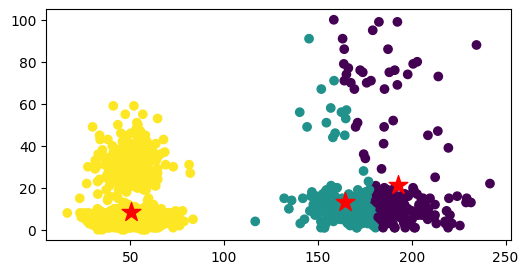

In [28]:
cDx, Dyp,cDxIni = MyKMeans(Dx, 3)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

# 🎯 **EJ 2: COMPARE SUS RESULTADOS CON SCIKIT-LEARN**

Centros encontrados por...
el método programado:
[[192.8347      21.33      ]
 [164.5765641   13.20512821]
 [ 50.31548005   8.65710723]]
el método de Sci-kit Learn:
[[179.3065043   10.59025788]
 [ 50.2373624    5.21586848]
 [175.6826087   68.36956522]
 [ 50.84858537  32.14146341]]


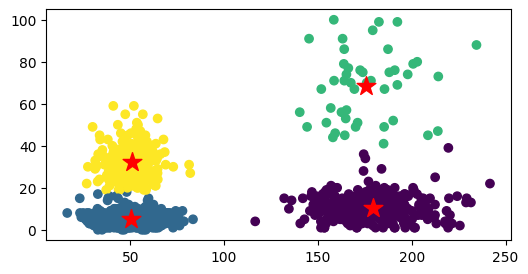

In [45]:
from sklearn.cluster import KMeans

# Se inicializa KMeans con el número de clústeres a buscar
modelo = KMeans(n_clusters=4) # 2.1 Completa el codigo aqui
# Se entrena el modelo
modelo.fit(Dx)
 # 2.2 Completa el codigo aqui
# Se predice los clusters
Dyp_sk =  modelo.predict(Dx)
# Obtener los centros de los clústeres
cDx_sk = modelo.cluster_centers_

# Comparing with scikit-learn centroids
print('Centros encontrados por...')
print('el método programado:')
print(cDx)
print('el método de Sci-kit Learn:')
print(cDx_sk)

# Ver asignaciones finales
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp_sk)
ax.scatter(cDx_sk[:,0],cDx_sk[:,1], marker='*', s=200, c='r')


### 📈 **RESULTADOS:**
**Conteste las siguientes preguntas**

¿Porque difieren los grupos de sklearn con el algoritmo que tu implementaste?

Una de las diferencias es que nuestro algoritmo MyKMeans utiliza una inicialización totalmente aleatoria, random. Scikit-learn utiliza por defecto k-means++, el cual es un método inteligente que elige los centros iniciales distantes entre sí para acelerar la convergencia y evitar óptimos locales pobres.


# 🎯 **EJ 3: USA LAS METRICAS INTRINSECAS Y EXTRINSECAS PARA DECIDIR QUE TAN BIEN AGRUPADOS ESTAN LOS DATOS**

In [46]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(Dx, Dyp_sk)
print(silhouette_avg)


0.5900131037332426


In [47]:
from sklearn.metrics import calinski_harabasz_score

calinski_harabasz_score_avg = calinski_harabasz_score(Dx, Dyp_sk)
print(calinski_harabasz_score_avg)


10596.232506708026


In [48]:
def medida_R_cuadrado(X, Xyp, cXs):
    centros_dataset = np.mean(X, axis=0)
    n_clusters = np.sort(np.unique(Xyp))

    distancia_a_centros_dataset = np.sum((X - centros_dataset)**2)

    distancias_intracluster = np.zeros(n_clusters.size)
    for k in np.arange(n_clusters.size):
        distancias_intracluster[k] = np.sum((X[Xyp==n_clusters[k], :] - cXs[n_clusters[k], :])**2)

    distancia_intracluster_total = np.sum(distancias_intracluster)

    r2 = 1 - (distancia_intracluster_total / distancia_a_centros_dataset)
    return r2

In [49]:
# 3.4 usa R cuadrado
r2_score = medida_R_cuadrado(Dx, Dyp_sk, cDx_sk)
print(f"R-Cuadrado: {r2_score:.4f}")

# Función auxiliar para Inercia (aunque sklearn ya tiene .inertia_)
def calcular_inercia(X, labels, centros):
    inercia = 0
    for i, centro in enumerate(centros):
        puntos_cluster = X[labels == i]
        if len(puntos_cluster) > 0:
            distancias = np.sum((puntos_cluster - centro) ** 2, axis=1)
            inercia += np.sum(distancias)
    return inercia

R-Cuadrado: 0.9409


In [50]:
def calcular_inercia(X, labels, centros):
    inercia = 0
    for i, centro in enumerate(centros):
        puntos_cluster = X[labels == i]
        if len(puntos_cluster) > 0:
            distancias = np.sum((puntos_cluster - centro) ** 2, axis=1)
            inercia += np.sum(distancias)
    return inercia

In [51]:
#3.8 usa la inercia

inercia_calc = calcular_inercia(Dx, Dyp_sk, cDx_sk)
print(f"Inercia (calculada): {inercia_calc:.4f}")
print(f"Inercia (sklearn attribute): {modelo.inertia_:.4f}")

Inercia (calculada): 346982.4572
Inercia (sklearn attribute): 346982.4572


### 📈 **RESULTADOS:**
**Interpreta con las medidas intrinsecas que tan bien agrupado estan los clusters**

El valor de silhouette está en el rango de 0.51 a 0.70, lo que se considera una "Estructura Razonable". Esto indica que la mayoría de los puntos están bien ubicados dentro de los clusters y que hay una separación clara entre los grupos.

En Calinski-Harabasz es un valor muy alto lo que me dice que los clusters están muy bien definidos y que la relación entre la dispersión "entre-clusters" y "dentro-del-cluster" es muy favorable.

En R-Cuadrado indica que el 94.09% de la variabilidad total de los datos está explicada por la formación de estos 4 clusters.

En la inercia al tener un R-Cuadrado de 0.94, sabemos que representa el error o varianza no explicada es pequeña en comparación con la varianza total.


# 🚀 ¡TALLER FINALIZADO!"